In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

device="cuda"

#uncomment when using colab or local cpu
# train_dataset = torchvision.datasets.cifar.CIFAR100(root='cifar100', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.cifar.CIFAR100(root='cifar100', train=False, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#uncomment when using kaggle

train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/cifar10/cifar10/train", transform=transform)

test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/cifar10/cifar10/test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

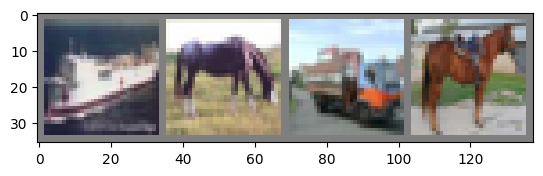

torch.Size([4])


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels.shape)

## ResNet

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


# print(net)

## 原始CNN

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # kernel_size=5, padding=2, stride=1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.conv1(x)
        # print("output shape of conv1:", x.size())
        # x = self.F.relu(x)
        
        # x = self.pool(x)
        
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




## SE-ResNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1): #需要确定输入维度和输出维度，步长默认为1
        super(ResidualBlock, self).__init__()
        #################
        if outchannel == 64:
            self.globalAvgPool = nn.AvgPool2d(32, stride=1)
        elif outchannel == 128:
            self.globalAvgPool = nn.AvgPool2d(16, stride=1)
        elif outchannel == 256:
            self.globalAvgPool = nn.AvgPool2d(8, stride=1)
        elif outchannel == 512:
            self.globalAvgPool = nn.AvgPool2d(4, stride=1)

        self.fc1 = nn.Linear(in_features=outchannel, out_features=round(outchannel / 16))
        self.fc2 = nn.Linear(in_features=round(outchannel / 16), out_features=outchannel)
        self.sigmoid = nn.Sigmoid()
        ####################

        ####################
        # self.seg = nn.Sequential(
        #
        # )
        ####################
        self.left = nn.Sequential(  #残差主体部分
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False), #第一个卷积把输入维度转成输出维度，步长可变
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),#第二个卷积输入和输出的维度都是一样的，都为输出维度，步长为1
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()  #一般而言，shortcut不做操作，输入x就输出x
        if stride != 1 or inchannel != outchannel: #但是block的步长万一不是1 或者 block的输入维度与输出维度不一致
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False), #shortcut的卷积，若步长不为1或者输入维度与输出维度不一致，就会触发
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):  #block的前向反馈，包含主体的2个卷积和shortcut可能触发的一个卷积
        out = self.left(x)     #Residual主体
        original_out = out
        ###seg
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out
        ###

        out += self.shortcut(x)#shortcut
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64  #输入网络后，遇到的第一个卷积是3x3，64层的
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), #输入维度是3，因为一开始输入是RGB，卷积是3x3，64
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1) #4个卷积是 3x3，64层的，其中有两个block，每个block2个卷积
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)#4个卷积是 3x3，128层的，其中有两个block，每个block2个卷积
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)#4个卷积是 3x3，256层的，其中有两个block，每个block2个卷积
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)#4个卷积是 3x3，512层的，其中有两个block，每个block2个卷积
        self.fc = nn.Linear(512, num_classes)   #最后的全连接层，512层要转成10层，因为cifar数据集是10分类的

    def make_layer(self, block, channels, num_blocks, stride):#制造layer，一个layer 两个block
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1],或[2,1]
        layers = []
        for stride in strides:#制造不同步长(1或者2)的block，一个block两个卷积，可能触发shortcut的第三个卷积（l不同layer之间的卷积会触发）
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)             #只有最开始的一个卷积
        out = self.layer1(out)          #4个64层3x3卷积
        out = self.layer2(out)          #4个128层3x3卷积
        out = self.layer3(out)          #4个256层3x3卷积
        out = self.layer4(out)          #4个512层3x3卷积
        out = F.avg_pool2d(out, 4)      #最后的输出是4x4的，所以这里第二个参数为4
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def SE_ResNet18():

    return ResNet(ResidualBlock)



## DenseNet

In [6]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)



In [7]:
def NetType(type):
    if type=="originalCNN":
        return Net().to(device)
    
    if type=="ResNet":
        return resnet18().to(device)
    
    if type=="SE-ResNet":
        return SE_ResNet18().to(device)
    
    if type=="DenseNet":
        return densenet121().to(device)


net=NetType("DenseNet") #需要什么网络，改一下参数就可以
print(net)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottle_neck_layer_0): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottle_neck_layer_1): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(12

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
print(len(train_loader))

12500


In [9]:
from tqdm import tqdm
def train(epoch):
    net.train()
    # Loop over each batch from the training set
    train_tqdm = tqdm(train_loader, desc="Epoch " + str(epoch))
    for batch_idx, (data, target) in enumerate(train_tqdm):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        # Zero gradient buffers
        optimizer.zero_grad()
        # Pass data through the network
        output = net(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()  # w - alpha * dL / dw
        train_tqdm.set_postfix({"loss": "%.3g" % loss.item()})

def validate(lossv,top1AccuracyList,top5AccuracyList):
    net.eval()
    val_loss = 0
    top1Correct = 0
    top5Correct = 0
    for index,(data, target) in enumerate(test_loader):
        data = data.to(device)
        labels = target.to(device)
        outputs = net(data)
        val_loss += criterion(outputs, labels).data.item()
        _, top1Predicted = torch.max(outputs.data, 1)
        top5Predicted = torch.topk(outputs.data, k=5, dim=1, largest=True)[1]
        top1Correct += (top1Predicted == labels).cpu().sum().item()
        label_resize = labels.view(-1, 1).expand_as(top5Predicted)
        top5Correct += torch.eq(top5Predicted, label_resize).view(-1).cpu().sum().float().item()

    val_loss /= len(test_loader)
    lossv.append(val_loss)

    top1Acc=100*top1Correct / len(test_loader.dataset)
    top5Acc=100*top5Correct / len(test_loader.dataset)
    top1AccuracyList.append(top1Acc)
    top5AccuracyList.append(top5Acc)
    
    print('\nValidation set: Average loss: {:.4f}, Top1Accuracy: {}/{} ({:.0f}%) Top5Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, top1Correct, len(test_loader.dataset), top1Acc,top5Correct, len(test_loader.dataset), top5Acc))
#     accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
#     accv.append(accuracy)

In [10]:
lossv = []
top1AccuracyList = []   # top1准确率列表
top5AccuracyList = []   # top5准确率列表
max_epoch = 20
for epoch in range(max_epoch):  # loop over the dataset multiple times
    train(epoch)
    with torch.no_grad():
        validate(lossv,top1AccuracyList,top5AccuracyList)
        
print('Finished Training')

Epoch 0: 100%|██████████| 12500/12500 [11:43<00:00, 17.78it/s, loss=1.45]



Validation set: Average loss: 1.3464, Top1Accuracy: 5081/10000 (51%) Top5Accuracy: 9405.0/10000 (94%)



Epoch 1: 100%|██████████| 12500/12500 [11:30<00:00, 18.11it/s, loss=0.791]



Validation set: Average loss: 1.1692, Top1Accuracy: 5712/10000 (57%) Top5Accuracy: 9537.0/10000 (95%)



Epoch 2: 100%|██████████| 12500/12500 [11:42<00:00, 17.79it/s, loss=0.409]



Validation set: Average loss: 0.9783, Top1Accuracy: 6582/10000 (66%) Top5Accuracy: 9722.0/10000 (97%)



Epoch 3: 100%|██████████| 12500/12500 [11:37<00:00, 17.92it/s, loss=1.49]



Validation set: Average loss: 0.8354, Top1Accuracy: 7128/10000 (71%) Top5Accuracy: 9778.0/10000 (98%)



Epoch 4: 100%|██████████| 12500/12500 [11:27<00:00, 18.19it/s, loss=0.662]



Validation set: Average loss: 0.7803, Top1Accuracy: 7299/10000 (73%) Top5Accuracy: 9799.0/10000 (98%)



Epoch 5: 100%|██████████| 12500/12500 [11:35<00:00, 17.96it/s, loss=0.241]



Validation set: Average loss: 0.7048, Top1Accuracy: 7619/10000 (76%) Top5Accuracy: 9847.0/10000 (98%)



Epoch 6: 100%|██████████| 12500/12500 [11:45<00:00, 17.72it/s, loss=0.7]



Validation set: Average loss: 0.6583, Top1Accuracy: 7754/10000 (78%) Top5Accuracy: 9874.0/10000 (99%)



Epoch 7: 100%|██████████| 12500/12500 [11:26<00:00, 18.22it/s, loss=0.483]



Validation set: Average loss: 0.6338, Top1Accuracy: 7858/10000 (79%) Top5Accuracy: 9870.0/10000 (99%)



Epoch 8: 100%|██████████| 12500/12500 [11:27<00:00, 18.18it/s, loss=0.0296]



Validation set: Average loss: 0.5716, Top1Accuracy: 8054/10000 (81%) Top5Accuracy: 9903.0/10000 (99%)



Epoch 9: 100%|██████████| 12500/12500 [11:33<00:00, 18.03it/s, loss=0.397]



Validation set: Average loss: 0.5852, Top1Accuracy: 8035/10000 (80%) Top5Accuracy: 9901.0/10000 (99%)



Epoch 10: 100%|██████████| 12500/12500 [11:35<00:00, 17.97it/s, loss=0.69]



Validation set: Average loss: 0.6890, Top1Accuracy: 8036/10000 (80%) Top5Accuracy: 9886.0/10000 (99%)



Epoch 11: 100%|██████████| 12500/12500 [11:39<00:00, 17.87it/s, loss=0.175]



Validation set: Average loss: 0.5956, Top1Accuracy: 8132/10000 (81%) Top5Accuracy: 9887.0/10000 (99%)



Epoch 12: 100%|██████████| 12500/12500 [11:46<00:00, 17.69it/s, loss=0.544]



Validation set: Average loss: 0.5915, Top1Accuracy: 8164/10000 (82%) Top5Accuracy: 9895.0/10000 (99%)



Epoch 13: 100%|██████████| 12500/12500 [11:47<00:00, 17.66it/s, loss=0.0152]



Validation set: Average loss: 0.6308, Top1Accuracy: 8139/10000 (81%) Top5Accuracy: 9899.0/10000 (99%)



Epoch 14: 100%|██████████| 12500/12500 [11:28<00:00, 18.14it/s, loss=0.00453]



Validation set: Average loss: 0.6057, Top1Accuracy: 8131/10000 (81%) Top5Accuracy: 9900.0/10000 (99%)



Epoch 15: 100%|██████████| 12500/12500 [11:29<00:00, 18.13it/s, loss=0.0939]



Validation set: Average loss: 0.6156, Top1Accuracy: 8195/10000 (82%) Top5Accuracy: 9890.0/10000 (99%)



Epoch 16: 100%|██████████| 12500/12500 [11:18<00:00, 18.42it/s, loss=0.0016]



Validation set: Average loss: 0.6184, Top1Accuracy: 8234/10000 (82%) Top5Accuracy: 9885.0/10000 (99%)



Epoch 17: 100%|██████████| 12500/12500 [11:31<00:00, 18.09it/s, loss=0.0196]



Validation set: Average loss: 0.6481, Top1Accuracy: 8181/10000 (82%) Top5Accuracy: 9897.0/10000 (99%)



Epoch 18: 100%|██████████| 12500/12500 [11:28<00:00, 18.16it/s, loss=0.919]



Validation set: Average loss: 0.7003, Top1Accuracy: 8146/10000 (81%) Top5Accuracy: 9881.0/10000 (99%)



Epoch 19: 100%|██████████| 12500/12500 [11:22<00:00, 18.32it/s, loss=0.106]



Validation set: Average loss: 0.6530, Top1Accuracy: 8244/10000 (82%) Top5Accuracy: 9894.0/10000 (99%)

Finished Training


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

Text(0.5, 1.0, 'validation top5 accuracy')

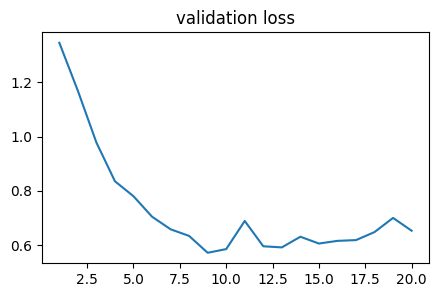

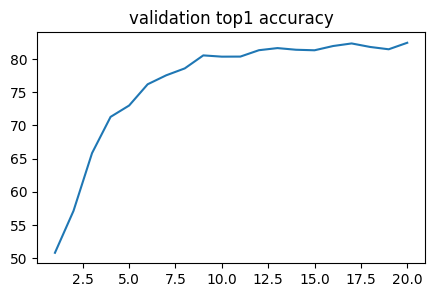

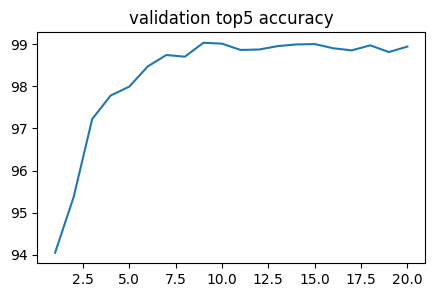

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# 绘制曲线
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, max_epoch + 1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, max_epoch + 1), top1AccuracyList)
plt.title('validation top1 accuracy')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, max_epoch + 1), top5AccuracyList)
plt.title('validation top5 accuracy')